In [8]:
!nvidia-smi

Thu Dec 17 19:26:08 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64       Driver Version: 440.64       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:08:00.0 Off |                    0 |
| N/A   26C    P0    33W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:0D:00.0 Off |                    0 |
| N/A   28C    P0    28W / 250W |      0MiB / 16280MiB |      4%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [9]:
import xml.etree.ElementTree as ET

import os
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data
from PIL import Image

In [ ]:
# !pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
# !pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

## Defining the Dataset

The [torchvision reference scripts for training object detection, instance segmentation and person keypoint detection](https://github.com/pytorch/vision/tree/v0.3.0/references/detection) allows for easily supporting adding new custom datasets.
The dataset should inherit from the standard `torch.utils.data.Dataset` class, and implement `__len__` and `__getitem__`.

The only specificity that we require is that the dataset `__getitem__` should return:

* image: a PIL Image of size (H, W)
* target: a dict containing the following fields
    * `boxes` (`FloatTensor[N, 4]`): the coordinates of the `N` bounding boxes in `[x0, y0, x1, y1]` format, ranging from `0` to `W` and `0` to `H`
    * `labels` (`Int64Tensor[N]`): the label for each bounding box
    * `image_id` (`Int64Tensor[1]`): an image identifier. It should be unique between all the images in the dataset, and is used during evaluation
    * `area` (`Tensor[N]`): The area of the bounding box. This is used during evaluation with the COCO metric, to separate the metric scores between small, medium and large boxes.
    * `iscrowd` (`UInt8Tensor[N]`): instances with `iscrowd=True` will be ignored during evaluation.
    * (optionally) `masks` (`UInt8Tensor[N, H, W]`): The segmentation masks for each one of the objects
    * (optionally) `keypoints` (`FloatTensor[N, K, 3]`): For each one of the `N` objects, it contains the `K` keypoints in `[x, y, visibility]` format, defining the object. `visibility=0` means that the keypoint is not visible. Note that for data augmentation, the notion of flipping a keypoint is dependent on the data representation, and you should probably adapt `references/detection/transforms.py` for your new keypoint representation

If your model returns the above methods, they will make it work for both training and evaluation, and will use the evaluation scripts from pycocotools.

Additionally, if you want to use aspect ratio grouping during training (so that each batch only contains images with similar aspect ratio), then it is recommended to also implement a `get_height_and_width` method, which returns the height and the width of the image. If this method is not provided, we query all elements of the dataset via `__getitem__` , which loads the image in memory and is slower than if a custom method is provided.


In [3]:
!unzip FaceMaskDataset.zip

Archive:  FaceMaskDataset.zip
   creating: train/
  inflating: train/test_00000127.xml  
  inflating: train/test_00000127.jpg  
  inflating: train/test_00000125.xml  
  inflating: train/test_00000125.jpg  
  inflating: train/test_00000123.xml  
  inflating: train/test_00000123.jpg  
  inflating: train/test_00000122.xml  
  inflating: train/test_00000122.jpg  
  inflating: train/test_00000121.xml  
  inflating: train/test_00000121.jpg  
  inflating: train/test_00000120.xml  
  inflating: train/test_00000120.jpg  
  inflating: train/test_00000118.xml  
  inflating: train/test_00000118.jpg  
  inflating: train/test_00000117.xml  
  inflating: train/test_00000117.jpg  
  inflating: train/test_00000116.xml  
  inflating: train/test_00000116.jpg  
  inflating: train/test_00000114.xml  
  inflating: train/test_00000114.jpg  
  inflating: train/test_00000111.xml  
  inflating: train/test_00000111.jpg  
  inflating: train/test_00000110.xml  
  inflating: train/test_00000110.jpg  
  inflating: t

Parser for target

In [10]:
def target_xml_parser(target_path):
    tree = ET.parse(target_path)
    root = tree.getroot()
    d = {"label" : [],
        "ymin" : [],
        "ymax" : [],
        "xmin" : [],
        "xmax" : []}
    for ch in root:
        if ch.tag == "object":
            for box in ch.getchildren():
                if box.tag == "bndbox":
                    for coord in box.getchildren():
                        if coord.tag in ("ymin","ymax","xmin","xmax"):
                            d[coord.tag].append(int(coord.text))
                if box.tag == "name":
                    if box.text == "face":
                        d["label"].append(2)
                    if box.text == "face_mask":
                        d["label"].append(1)
                            
    return d

In [7]:
# cleaning of empty bboxex
root = "val"
targets = list(sorted([f for f in os.listdir(os.path.join(root)) if f[-4:] == ".xml"]))

for target_file in targets:
    target_path = os.path.join(root, target_file)
    d = target_xml_parser(target_path)
    if len(d["label"]) == 0:
        print(target_path)
        os.remove(target_path)
        os.remove(target_path[:-4] + ".jpg")

val/test_00000306.xml


In [11]:
#dataset
class DetectMaskDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted([f for f in os.listdir(os.path.join(root)) if f[-4:] == ".jpg"]))
        self.targets = list(sorted([f for f in os.listdir(os.path.join(root)) if f[-4:] == ".xml"]))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, self.imgs[idx])
        target_path = os.path.join(self.root, self.targets[idx])
        img = Image.open(img_path).convert('RGB')
        
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        
        boxes = []
        
        target_d = target_xml_parser(target_path)
        
        num_objs = len(target_d["label"])
        for i in range(num_objs):
            ymin = target_d["ymin"][i]
            ymax = target_d["ymax"][i]
            xmin = target_d["xmin"][i]
            xmax = target_d["xmax"][i]
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.as_tensor(target_d["label"], dtype=torch.int64)
        
        image_id = torch.tensor([idx])
        if num_objs: 
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        else:
            area = torch.tensor([], dtype=torch.float32)
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(np.zeros((num_objs, img.size[0], img.size[1])),
                                dtype=torch.uint8)
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id  #should be unique(maybe even for test and train)
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

That's all for the dataset. Let's see how the outputs are structured for this dataset

So we can see that by default, the dataset returns a `PIL.Image` and a dictionary
containing several fields, including `boxes`, `labels` and `masks`.

## Defining model

[Faster R-CNN](https://arxiv.org/abs/1506.01497). Faster R-CNN is a model that predicts both bounding boxes and class scores for potential objects in the image.

![Faster R-CNN](https://raw.githubusercontent.com/pytorch/vision/temp-tutorial/tutorials/tv_image03.png)

In [12]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

That's it, this will make model be ready to be trained and evaluated on our custom dataset.

## Training and evaluation functions

In `references/detection/,` we have a number of helper functions to simplify training and evaluating detection models.
Here, we will use `references/detection/engine.py`, `references/detection/utils.py` and `references/detection/transforms.py`.

Let's copy those files (and their dependencies) in here so that they are available in the notebook

In [13]:
# %%shell

# # Download TorchVision repo to use some files from
# # references/detection
# git clone https://github.com/pytorch/vision.git
# cd vision
# git checkout v0.3.0

# cp references/detection/utils.py ../
# cp references/detection/transforms.py ../
# cp references/detection/coco_eval.py ../
# cp references/detection/engine.py ../
# cp references/detection/coco_utils.py ../

Let's write some helper functions for data augmentation / transformation, which leverages the functions in `references/detection` that we have just copied:


In [14]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [15]:
# use our dataset and defined transformations
dataset = DetectMaskDataset('train', get_transform(train=True))
dataset_test = DetectMaskDataset('train', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-100])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-100:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

In [16]:
len(dataset)

6018

In [17]:
img = np.array(dataset[0][0])

mean = np.mean(img, axis=2).mean(axis=1)

((img - mean[:, None, None]) / mean[:, None, None]).shape

(3, 1540, 1024)

In [18]:
dataset[0][0].squeeze(0).size()

torch.Size([3, 1540, 1024])

Now let's instantiate the model and the optimizer

In [19]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has tree classes only - background and mask/unmask
num_classes = 3

# get the model using our helper function
model = get_model(num_classes)

# move model to the right device
# model= nn.DataParallel(model,device_ids = [0, 1])
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

And now let's train the model for 10 epochs, evaluating at the end of every epoch.

In [20]:
# let's train it for 10 epochs
num_epochs = 4

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Epoch: [0]  [   0/3009]  eta: 0:37:42  lr: 0.000010  loss: 20.8325 (20.8325)  loss_classifier: 1.4912 (1.4912)  loss_box_reg: 0.0393 (0.0393)  loss_mask: 2.1911 (2.1911)  loss_objectness: 6.3637 (6.3637)  loss_rpn_box_reg: 10.7472 (10.7472)  time: 0.7520  data: 0.3617  max mem: 2136
Epoch: [0]  [  10/3009]  eta: 0:22:18  lr: 0.000060  loss: 2.4046 (4.2555)  loss_classifier: 1.3730 (1.3530)  loss_box_reg: 0.0357 (0.0545)  loss_mask: 0.5272 (0.8048)  loss_objectness: 0.3108 (1.0033)  loss_rpn_box_reg: 0.0198 (1.0399)  time: 0.4464  data: 0.0553  max mem: 3411
Epoch: [0]  [  20/3009]  eta: 0:20:53  lr: 0.000110  loss: 2.2188 (5.1970)  loss_classifier: 1.0333 (1.0117)  loss_box_reg: 0.0357 (0.0529)  loss_mask: 0.2589 (0.6758)  loss_objectness: 0.2249 (1.2199)  loss_rpn_box_reg: 0.0198 (2.2368)  time: 0.4029  data: 0.0175  max mem: 3737
Epoch: [0]  [  30/3009]  eta: 0:20:34  lr: 0.000160  loss: 0.6285 (3.6800)  loss_classifier: 0.3249 (0.7412)  loss_box_reg: 0.0371 (0.0499)  loss_mask: 0.07

In [21]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 43,705,377 trainable parameters


In [22]:
model.eval()
torch.save(model, 'fasterrcnn_resnet50_fpn.pth')

Now that training has finished, let's have a look at what it actually predicts in a test image

In [148]:
# pick one image from the test set
img, _ = dataset_test[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

Printing the prediction shows that we have a list of dictionaries. Each element of the list corresponds to a different image. As we have a single image, there is a single dictionary in the list.
The dictionary contains the predictions for the image we passed. In this case, we can see that it contains `boxes`, `labels`, `masks` and `scores` as fields.

In [205]:
img, _ = dataset_test[15]

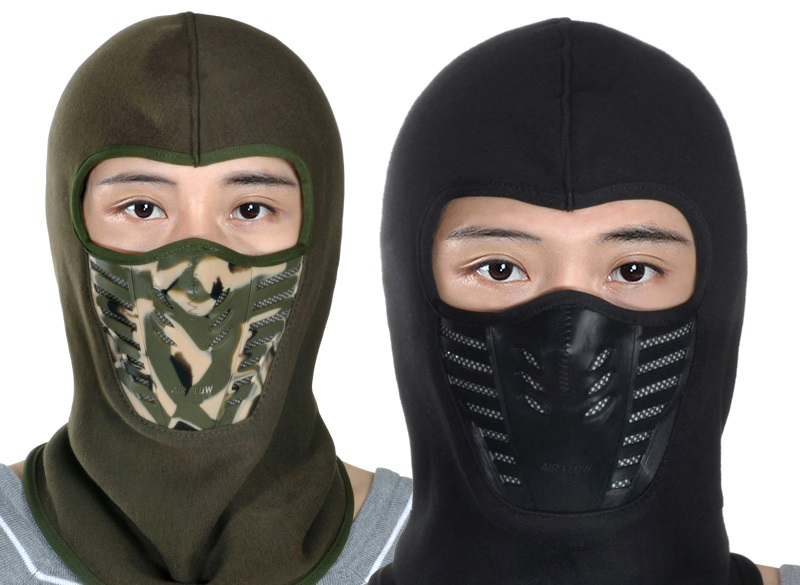

In [206]:
img = img.mul(255).permute(1, 2, 0).byte().numpy()
Image.fromarray(img)

And let's now visualize the top predicted segmentation mask. The masks are predicted as `[N, 1, H, W]`, where `N` is the number of predictions, and are probability maps between 0-1.

In [207]:
from PIL import Image

In [208]:
img = Image.fromarray(img)

In [209]:
import matplotlib.pyplot as plt

In [210]:
prediction[0]

{'boxes': tensor([[2.2254e+00, 7.0079e+01, 1.9464e+02, 4.1057e+02],
         [8.9507e+01, 1.2076e+02, 3.4826e+02, 4.7921e+02],
         [3.9599e+01, 1.9133e+01, 2.6933e+02, 3.2867e+02],
         [1.1878e+02, 4.1504e+01, 2.4280e+02, 2.0000e+02],
         [9.5989e+01, 7.4129e+01, 2.3421e+02, 2.6327e+02],
         [1.6879e+02, 4.5522e+01, 4.1828e+02, 3.8510e+02],
         [2.0653e+02, 5.3536e+01, 3.3661e+02, 2.3148e+02],
         [3.6131e+00, 2.0516e+02, 2.1626e+02, 5.1797e+02],
         [1.8041e+01, 5.9832e+01, 1.4895e+02, 2.4703e+02],
         [1.7234e+02, 5.2885e+01, 2.9203e+02, 2.1853e+02],
         [7.2627e+01, 5.5549e+01, 1.9814e+02, 2.1798e+02],
         [5.2799e+01, 3.0168e+02, 1.8246e+02, 4.7543e+02],
         [1.8705e+02, 9.2382e+01, 3.2182e+02, 2.8142e+02],
         [1.4602e+02, 1.0121e+01, 3.6975e+02, 2.6221e+02],
         [2.6231e+02, 8.4995e+01, 4.2118e+02, 4.8099e+02],
         [9.7147e+01, 1.7777e+01, 2.0814e+02, 1.5290e+02],
         [1.3308e+02, 1.0440e+02, 2.6561e+02, 2

In [211]:
#non maximum suppression
def nms(bounding_boxes, confidence_score, threshold):
    # If no bounding boxes, return empty list
    if len(bounding_boxes) == 0:
        return [], []

    # Bounding boxes
    boxes = np.array(bounding_boxes)

    # coordinates of bounding boxes
    start_x = boxes[:, 0]
    start_y = boxes[:, 1]
    end_x = boxes[:, 2]
    end_y = boxes[:, 3]

    # Confidence scores of bounding boxes
    score = np.array(confidence_score)

    # Picked bounding boxes
    picked_boxes = []
    picked_score = []

    # Compute areas of bounding boxes
    areas = (end_x - start_x + 1) * (end_y - start_y + 1)

    # Sort by confidence score of bounding boxes
    order = np.argsort(score)

    # Iterate bounding boxes
    while order.size > 0:
        # The index of largest confidence score
        index = order[-1]

        # Pick the bounding box with largest confidence score
        picked_boxes.append(bounding_boxes[index])
        picked_score.append(confidence_score[index])

        # Compute ordinates of intersection-over-union(IOU)
        x1 = np.maximum(start_x[index], start_x[order[:-1]])
        x2 = np.minimum(end_x[index], end_x[order[:-1]])
        y1 = np.maximum(start_y[index], start_y[order[:-1]])
        y2 = np.minimum(end_y[index], end_y[order[:-1]])

        # Compute areas of intersection-over-union
        w = np.maximum(0.0, x2 - x1 + 1)
        h = np.maximum(0.0, y2 - y1 + 1)
        intersection = w * h

        # Compute the ratio between intersection and union
        ratio = intersection / (areas[index] + areas[order[:-1]] - intersection)

        left = np.where(ratio < threshold)
        order = order[left]

    return picked_boxes, picked_score


In [212]:
new_boxes = nms(boxes, prediction[0]['scores'].cpu().numpy(), threshold=0.2)[0]

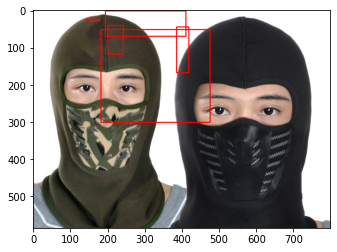

In [213]:
import cv2

# img_draw = img.mul(255).permute(1, 2, 0).byte().numpy()
# print(img_draw.shape)

img_draw = np.uint8(img)
#draw = ImageDraw.Draw(img_draw)

boxes = prediction[0]["boxes"].detach().cpu().numpy().astype(int)

for box in new_boxes:
    start_point = (box[2], box[0])
    end_point = (box[3], box[1])
#     print(start_point, end_point)
    cv2.rectangle(img_draw, start_point, end_point, (255, 0, 0), 2)

plt.imshow(img_draw)